Connections that exist for most subjects after corrections only

In [2]:
import pickle
from pymania import *
import matplotlib.pyplot as plt
import pickle as pk
import numpy as np
from scipy.spatial.distance import squareform,pdist

{'Constantine': <class 'pymania.solvers.constantine.Constantine'>, 'MRP_F': <class 'pymania.solvers.mrp_symm_force.MRP_F'>, 'MRP_NF': <class 'pymania.solvers.mrp_symm_noforce.MRP_NF'>, 'Solver': <class 'pymania.solvers.base.Solver'>}


In [3]:
from collections import defaultdict

In [4]:
rois = [f'L{i}' for i in range(1,181)]
roi2ind = {}
ind2roi = {}
for i,roi in enumerate(sorted(rois)):
    roi2ind[roi]=i
    ind2roi[i]=roi
def link_type(x,q1,q2):
    if x<q1:
        return 0#'short-range'
    elif x>q2:
        return 2#'long-range'
    else:
        return 1#'mid-range'
with open('L_ROIs.txt') as f:
    st = f.readlines()
    roi_names = [xx.strip().split('_')[1] for xx in st]

In [5]:
with open('All_Subjects_networks.pkl','rb') as f:
    data = pickle.load(f)
sdata = data['sparse']
vdata = data['vdense']

In [6]:
threshold = 5
val = np.zeros((180,180))
cnan = np.zeros((180,180),dtype='uint8')
for sub in sdata.subjects:
    for i,roi1 in enumerate(['L'+str(i) for i in range(1,181)]):
        for j,roi2 in enumerate(['L'+str(i) for i in range(1,181)]):
            if i==j:continue
            tmp = vdata.subjects[sub](roi1,roi2)
            xd = tmp.axonal_distance(threshold)
            if np.isnan(xd):
                cnan[i,j]+=1
                continue
            val[i,j] += xd
val[cnan==len(sdata)] = np.nan
val = val/(len(sdata)-cnan)

In [7]:
with open('euclidean.pk','rb') as f:
    E = pk.load(f)['l']

In [8]:
x = []
y = []
EE = squareform(E)
for i in range(180):
    for j in range(180):
        if i==j or np.isnan(val[i,j]) or min(val[i,j],EE[i,j])<1:continue
        x.append(EE[i,j])
        y.append(val[i,j])

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Text(0,0.5,'Axonal distance')

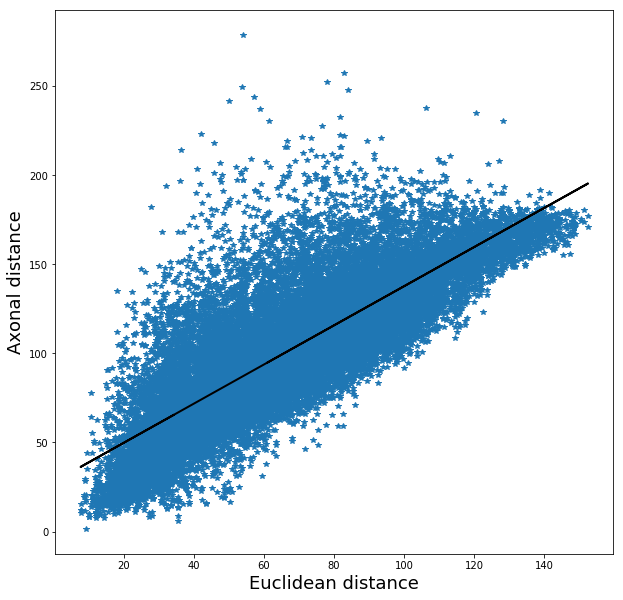

In [9]:
from sklearn.linear_model import LinearRegression
x = np.array(x)
y = np.array(y)
xr = np.array(x).reshape(-1, 1)
yr = np.array(y).reshape(-1, 1)
reg = LinearRegression().fit(xr, yr)
slope = reg.coef_[0][0]
intercept = reg.intercept_[0]
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(x,y,'*')
plt.plot(x,slope*x+intercept,'k-',lw=2)
plt.xlabel('Euclidean distance',fontsize=18)
plt.ylabel('Axonal distance',fontsize=18)

In [10]:
# percentage of nans (no axonal information)
100*np.count_nonzero(np.isnan(val))/180/179

17.50155183116077

In [11]:
ind = np.isnan(val)
val[ind] = slope*EE[ind] + intercept
dist = np.copy(val)

In [12]:
lengths = [dist[i,j] for i in range(179) for j in range(i+1,180)]

Text(0.5,0,'Axonal distance(mm)')

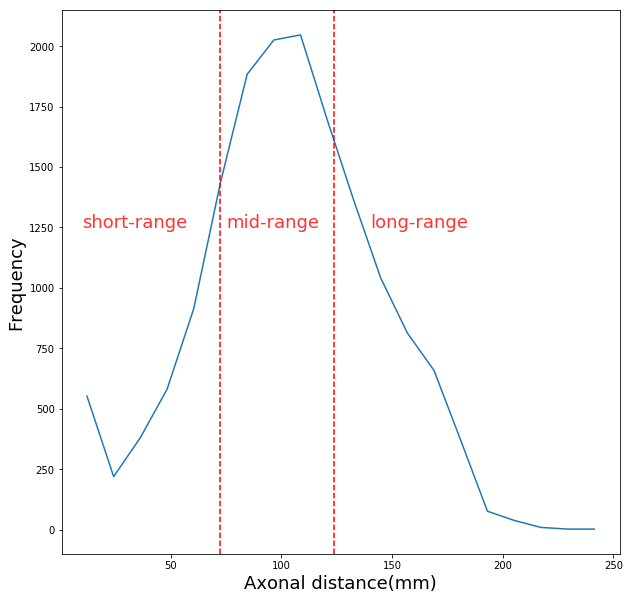

In [13]:
x,y = np.histogram(lengths, bins=20)
mid1,mid2 = np.percentile(lengths,[25,75])
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(y[1:],x)
plt.axvline(mid1,color='red',ls='dashed')
plt.axvline(mid2,color='red',ls='dashed')
plt.ylabel('Frequency',fontsize=18)
plt.text(10,1250,'short-range',fontsize=18,color='red',alpha=.8)
plt.text(75,1250,'mid-range',fontsize=18,color='red',alpha=.8)
plt.text(140,1250,'long-range',fontsize=18,color='red',alpha=.8)
plt.xlabel('Axonal distance(mm)',fontsize=18)

In [14]:
dif = np.zeros((180,180))
mid1,mid2 = np.percentile(lengths,[25,75])
p = np.zeros(3)
p1 = np.zeros(3)
p2d = np.zeros(3)
p2s = np.zeros(3)
ppd = np.zeros(3)
pps = np.zeros(3)
ds = []
for sub in sdata.subjects:
    print(sub)
    net2s = sdata.subjects[sub].mania2_network
    net1 = vdata.subjects[sub].mania1_network
    net2d = vdata.subjects[sub].mania2_network
    d1 = utils.density(net2d)
    d2 = utils.density(net2s)
    net27 = vdata.subjects[sub].proportional_net(d1)
    net10 = vdata.subjects[sub].proportional_net(d2)
    dif += (net2d-net27)
    ds += [(d1,d2)] 
    for i in range(180):
        for j in range(180):
            if i==j:continue
            roi1 = ind2roi[i]
            roi2 = ind2roi[j]
            t = dist[int(roi1[1:])-1,int(roi2[1:])-1]
            kind = link_type(t,mid1,mid2)
            p[kind]+=1
            if net27[i,j]>0.5:
                ppd[kind]+=1
            if net10[i,j]>0.5:
                pps[kind]+=1
            if net1[i,j]>0.5:
                p1[kind]+=1
            if net2d[i,j]>0.5:
                p2d[kind]+=1
            if net2s[i,j]>0.5:
                p2s[kind]+=1

126426
135124
137431
144125
146735
152427
153227
177140
180533
186545
188145
192237
206323
227533
248238
360030
361234
362034
368753
401422
413934
453542
463040
468050
481042
825654
911849
917558
992673
558960
569965
644246
654552
680452
701535
804646
814548


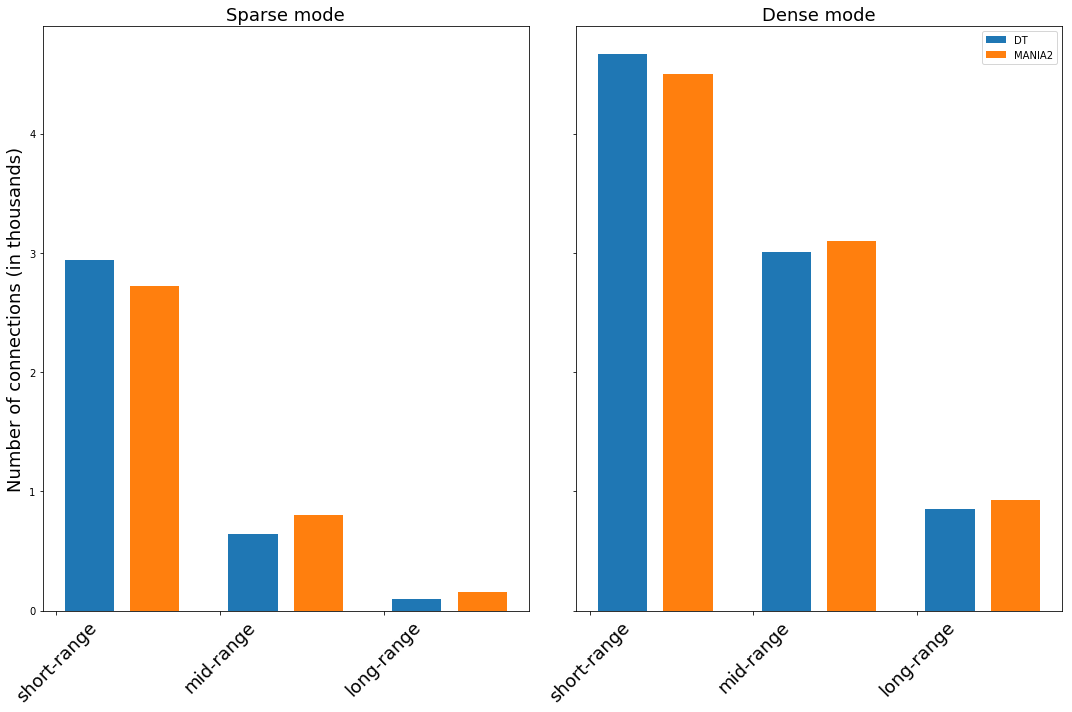

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,10),sharey=True)
ax[0].bar([1,2,3],pps/37000,width=.3)
ax[0].bar([1.4,2.4,3.4],p2s/37000,width=.3)
ax[0].set_xticks([.8,1.8,2.8])
ax[0].set_xticklabels(['short-range','mid-range','long-range'],rotation=45,fontsize=18)

ax[1].bar([1,2,3],ppd/37000,width=.3,label='DT')
ax[1].bar([1.4,2.4,3.4],p2d/37000,width=.3,label='MANIA2')
ax[1].legend()
ax[1].set_xticks([.8,1.8,2.8])
ax[1].set_xticklabels(['short-range','mid-range','long-range'],rotation=45,fontsize=18)
# ax[1].set_ylim([0,112])
# ax[0].set_ylim([0,112])
ax[0].set_ylabel('Number of connections (in thousands)',fontsize=18)
ax[0].set_title('Sparse mode',fontsize=18)
ax[1].set_title('Dense mode',fontsize=18)
plt.tight_layout()

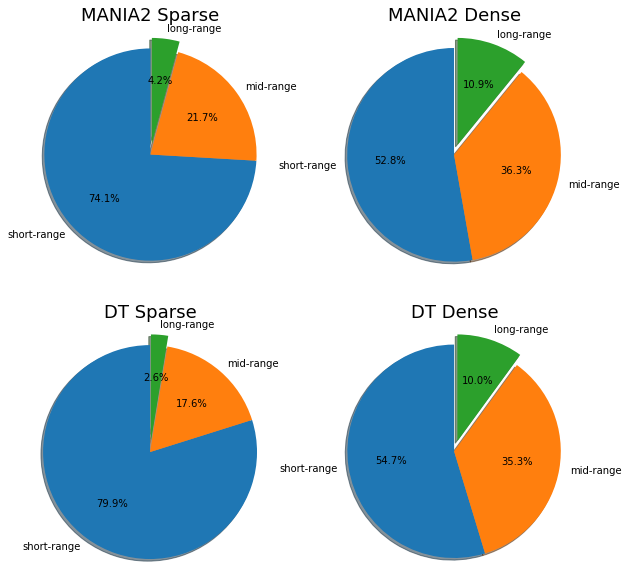

In [16]:
_p1 = 100*p1/np.sum(p1)
_p2d = 100*p2d/np.sum(p2d)
_p2s = 100*p2s/np.sum(p2s)
_ppd = 100*ppd/np.sum(ppd)
_pps = 100*pps/np.sum(pps)
fig1, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,1].pie(_p2d, explode=[0,0,.1], labels=['short-range','mid-range','long-range'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[0,1].axis('equal') 

ax[0,0].pie(_p2s, explode=[0,0,.1], labels=['short-range','mid-range','long-range'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[0,0].axis('equal') 

ax[1,1].pie(_ppd, explode=[0,0,.1], labels=['short-range','mid-range','long-range'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[1,1].axis('equal') 

ax[1,0].pie(_pps, explode=[0,0,.1], labels=['short-range','mid-range','long-range'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[1,0].axis('equal') 

ax[0,0].set_title('MANIA2 Sparse',fontsize=18)
ax[0,1].set_title('MANIA2 Dense',fontsize=18)
ax[1,0].set_title('DT Sparse',fontsize=18)
ax[1,1].set_title('DT Dense',fontsize=18)
plt.show()
plt.tight_layout()

In [23]:
q=0
print('"row"','"roi1"','"roi2"','"label1"','"label2"','"axonal distance"','"# Subjects"')
for i in range(180):
    for j in range(180):
        if dif[i,j]>21:
            q= q+1
            roi1 = ind2roi[i]
            roi2 = ind2roi[j]
            name1 = roi_names[int(roi1[1:])-1]
            name2 = roi_names[int(roi2[1:])-1]
            i1 = int(roi1[1:])-1
            i2 = int(roi2[1:])-1
            print(q,roi1,roi2,name1,name2,int(dist[i1,i2]),int(dif[i,j]))

"row" "roi1" "roi2" "label1" "label2" "axonal distance" "# Subjects"
1 L1 L75 V1 45 166 22
2 L15 L178 POS2 PI 97 23
3 L15 L75 POS2 45 163 29
4 L26 L133 SFL TE1p 145 23
5 L4 L112 V2 AAIC 110 22
6 L69 L151 9m PGs 170 27
7 L69 L51 9m 1 150 27
8 L69 L52 9m 2 149 22
9 L70 L149 8BL PFm 151 23
10 L70 L52 8BL 2 136 25
11 L72 L151 10d PGs 166 23
12 L75 L100 45 OP4 97 24
13 L75 L104 45 RI 91 23
14 L75 L129 45 STSdp 114 24
15 L75 L25 45 PSL 111 28
16 L76 L104 47l RI 99 24
17 L83 L148 p9-46v PF 107 22


In [19]:
37*.6

22.2

In [169]:
vdata.subjects.keys()

dict_keys([126426, 135124, 137431, 144125, 146735, 152427, 153227, 177140, 180533, 186545, 188145, 192237, 206323, 227533, 248238, 360030, 361234, 362034, 368753, 401422, 413934, 453542, 463040, 468050, 481042, 825654, 911849, 917558, 992673, 558960, 569965, 644246, 654552, 680452, 701535, 804646, 814548])

In [221]:
.27*37*180*179/2

160938.9